# Предсказание цены автомобилей

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from matplotlib import pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import CatBoostRegressor

### Первым делом читаем датасет и дропаем колонки которые точно не будем использовать

In [162]:
df = pd.read_csv('vehicles.csv')
df = df.drop(['id', 'url', 'region_url', 'image_url','county', 'VIN', 'lat', 'long', 'title_status', 'region', 'posting_date'], axis=1)

### Посмотрим на заполненность колонок

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   transmission  424324 non-null  object 
 9   drive         296313 non-null  object 
 10  size          120519 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
 13  description   426810 non-null  object 
 14  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 48.9+ MB


### Разбираться с фичами начнем с цены

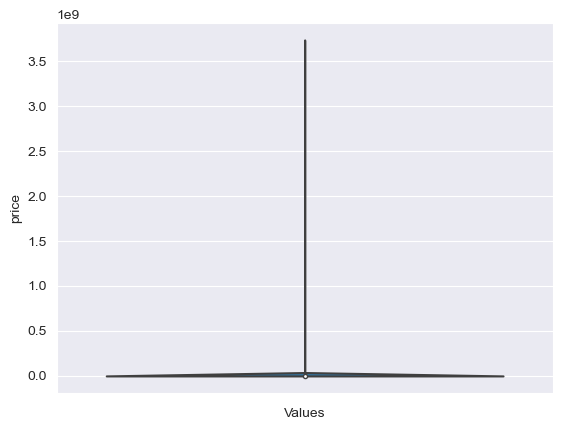

In [164]:
col = 'price'
df.replace(0, np.NaN)
data = df[col]
sns.violinplot(y=data)
plt.ylabel(col)
plt.xlabel('Values')
plt.show()

#### Картина удручающая, избавляемся от выбросов и проверяем результат, перед этим дропнем "бесплатные" автомобили

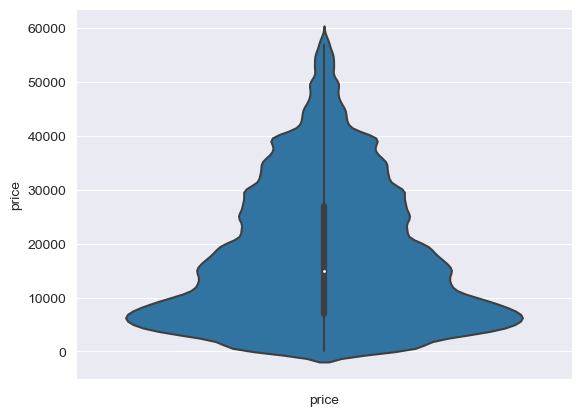

In [165]:
df = df[df[col] != 0]

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### Нормальным распределением тут и не пахнет, но стало определенно лучше

#### Перейдем к другим параметрам

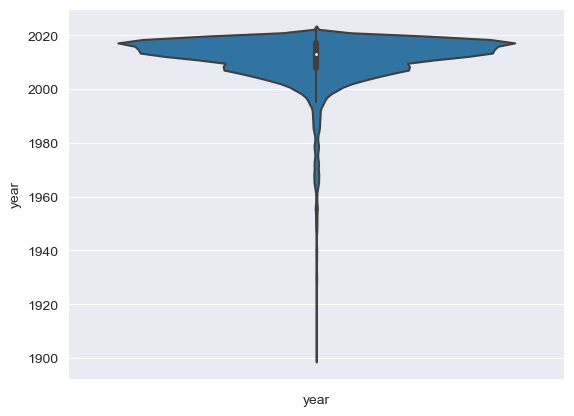

In [166]:
col = 'year'
data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### Избавимся от выбросов и заменим пропущенные значения на медиану

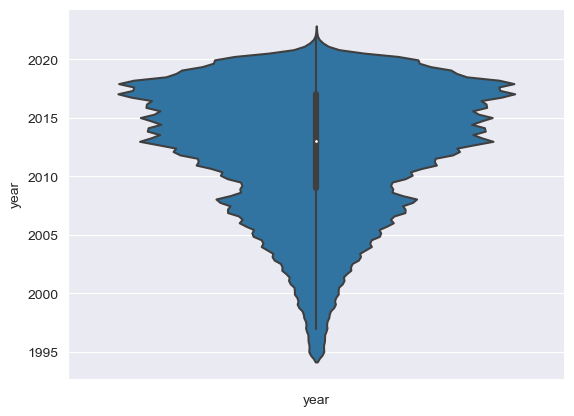

In [167]:
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

df[col].fillna(df[col].median(), inplace=True)

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### С производителем ничего не сделаешь, так что в дальнейшем дропнем строки где параметр не заполнен

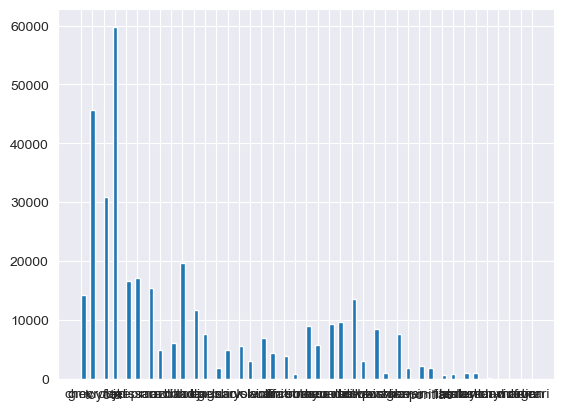

In [168]:
col = 'manufacturer'

df[col].hist(bins=100)
plt.show()

#### Модель - текстовый параметр, так что трогать его не будем

#### Пропущенные condition заменим на good как на наиболее частое и нейтральное значение

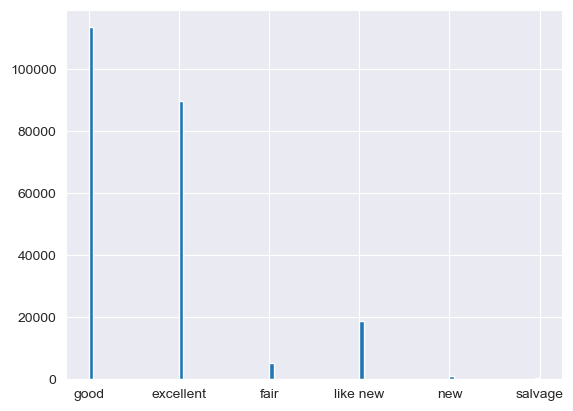

In [169]:
col = 'condition'

df[col].hist(bins=100)
plt.show()

df[col].fillna('good', inplace=True)

#### Количество цилиндров с болью заменим на моду

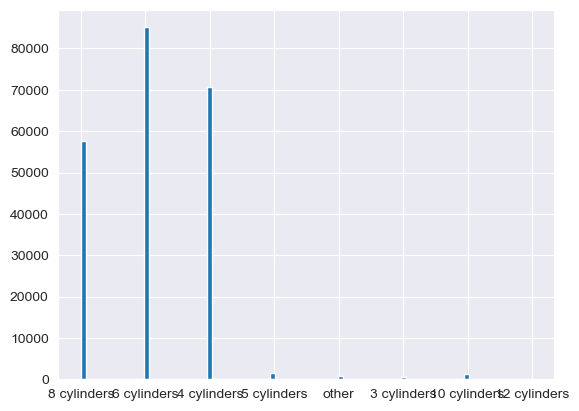

In [170]:
col = 'cylinders'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### Пропущенный тип топлива смело заменяем на gas

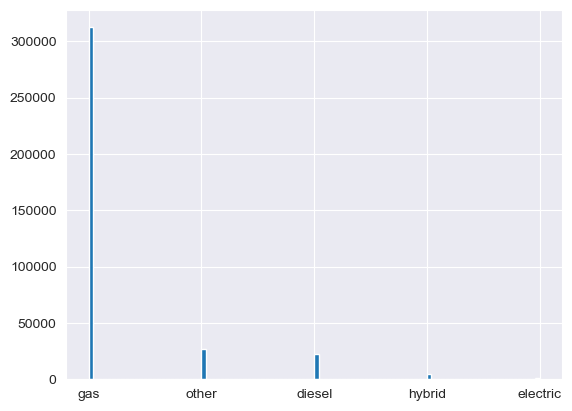

In [171]:
col = 'fuel'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### У пробега чиним выбросы и заменяем пропуски на медиану

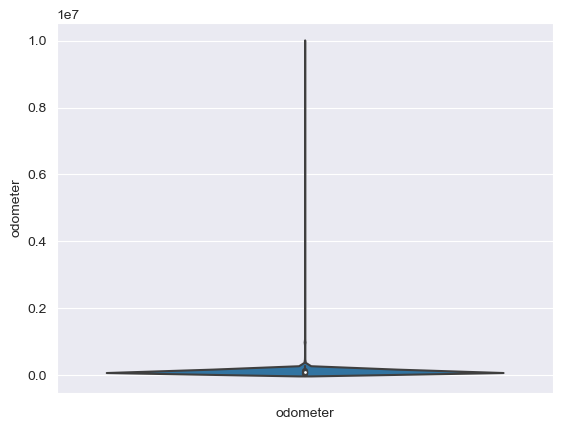

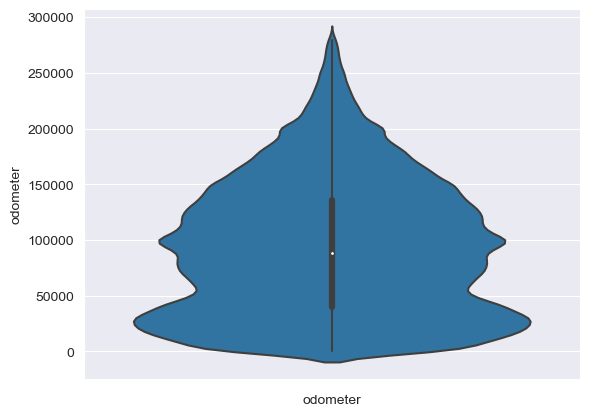

In [172]:
col = 'odometer'

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

df[col].fillna(df[col].median(), inplace=True)

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### Пропуски в трансмиссии заменяем на моду

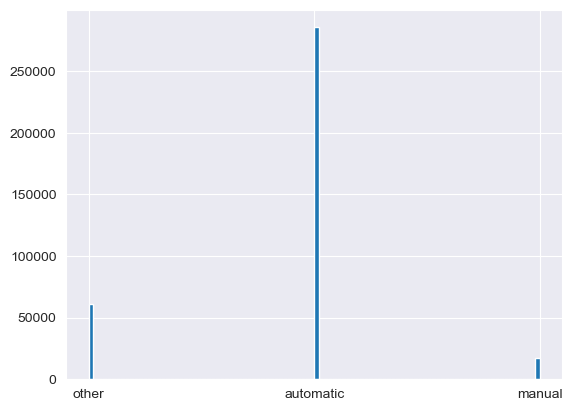

In [173]:
col = 'transmission'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### Привод оставляем как есть

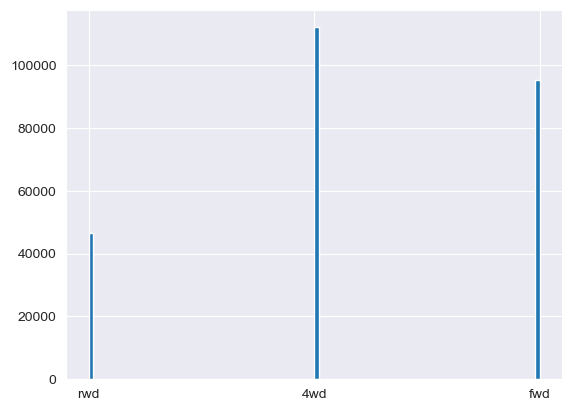

In [174]:
col = 'drive'

df[col].hist(bins=100)
plt.show()

#### Значание size заполнено только у трети записей, на что оптимальнее заменить - неясно. Дропнем колонку

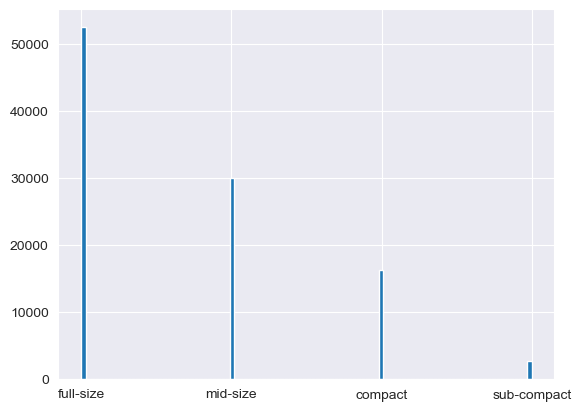

In [175]:
col = 'size'

df[col].hist(bins=100)
plt.show()

df=df.drop([col], axis=1)

#### Type оставим без изменений

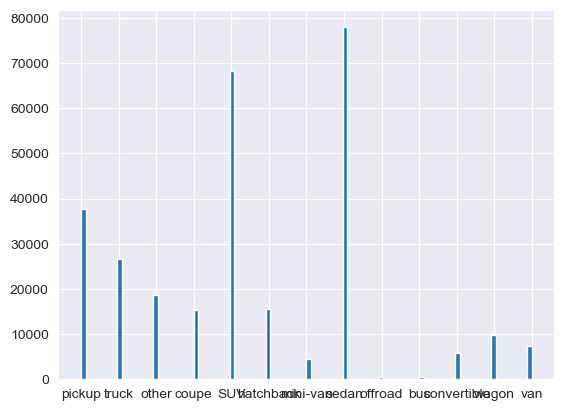

In [176]:
col = 'type'

df[col].hist(bins=100)
plt.show()

#### Пропуски в цвете заменим на белый, как на наиболее частое и нейтральное значение

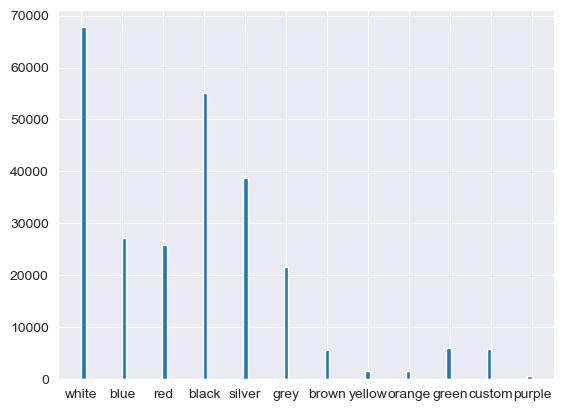

In [177]:
col = 'paint_color'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### Пропущенные значения штата заменим на моду, в предположении что это не окажет сильного влияния на определение цены в дальнейшем

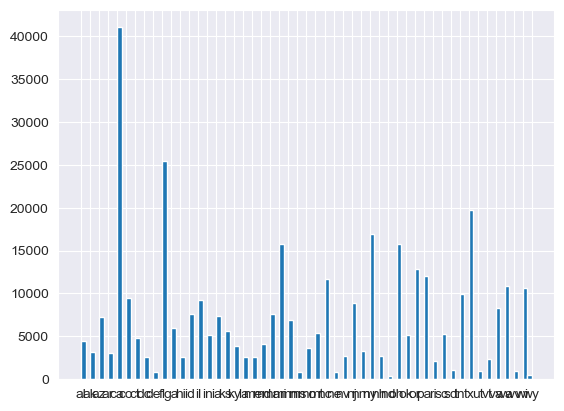

In [178]:
col = 'state'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

### Удалим строки с пропусками

In [179]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219503 entries, 31 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         219503 non-null  int64  
 1   year          219503 non-null  float64
 2   manufacturer  219503 non-null  object 
 3   model         219503 non-null  object 
 4   condition     219503 non-null  object 
 5   cylinders     219503 non-null  object 
 6   fuel          219503 non-null  object 
 7   odometer      219503 non-null  float64
 8   transmission  219503 non-null  object 
 9   drive         219503 non-null  object 
 10  type          219503 non-null  object 
 11  paint_color   219503 non-null  object 
 12  description   219503 non-null  object 
 13  state         219503 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 25.1+ MB


### Посмотрим как коррелируют наши величины, перед этим закодируем категориальные переменные

In [180]:
encoder = ce.CountEncoder()
df_num = encoder.fit_transform(df)

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        #select_dtypes([np.number])
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_num)

KeyboardInterrupt: 

### Начнем готовить данные для использования модели

In [181]:
target = 'price'
features = list(df.columns)
features.remove(target)
X = df[features]
y = df[[target]]

In [182]:
features

['year',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'transmission',
 'drive',
 'type',
 'paint_color',
 'description',
 'state']

### Определим индексы категориальных и текстовых переменных

In [183]:
cat_features = [1, 3, 4, 5, 7, 8, 9, 10, 12]
#cat_features = [1, 3, 4, 5, 7, 8, 9]
text_features = [2, 11]

### Произведем train-test split (поплачем что только на данном этапе)

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8, shuffle=True)

train_pool = Pool(
    data = X_train,
    label = y_train,
    cat_features = cat_features,
    text_features=text_features,
)

test_pool = Pool(
    data = X_test,
    label = y_test,
    cat_features = cat_features,
    text_features=text_features,
)

### Обучим модель CatBoostRegressor, будем обучать до тех пор пока ошибка не начнет расти

In [187]:
model = CatBoostRegressor(iterations=100000,
                          cat_features=cat_features,
                          text_features=text_features,
                          loss_function='RMSE',
                          task_type='GPU',
                          #early_stopping_rounds=100,
                          depth=8,
                          )

In [188]:
model.fit(train_pool,
          eval_set=test_pool,
          verbose=50,
          plot=False,
          )

Learning rate set to 0.029209
0:	learn: 12416.6786370	test: 12450.2504797	best: 12450.2504797 (0)	total: 264ms	remaining: 7h 19m 20s
50:	learn: 6615.0316848	test: 6613.0513776	best: 6613.0513776 (50)	total: 3.73s	remaining: 2h 1m 43s
100:	learn: 5431.5823856	test: 5432.4910550	best: 5432.4910550 (100)	total: 6.75s	remaining: 1h 51m 22s
150:	learn: 5023.7031474	test: 5036.8248896	best: 5036.8248896 (150)	total: 9.45s	remaining: 1h 44m 8s
200:	learn: 4814.6776570	test: 4840.3872931	best: 4840.3872931 (200)	total: 11.9s	remaining: 1h 38m 44s
250:	learn: 4668.6841645	test: 4702.0861378	best: 4702.0861378 (250)	total: 14.4s	remaining: 1h 35m 21s
300:	learn: 4554.3301031	test: 4592.3463316	best: 4592.3463316 (300)	total: 17s	remaining: 1h 33m 45s
350:	learn: 4461.1598650	test: 4504.3486209	best: 4504.3486209 (350)	total: 19.5s	remaining: 1h 32m 22s
400:	learn: 4376.4173333	test: 4424.6002649	best: 4424.6002649 (400)	total: 22s	remaining: 1h 31m 5s
450:	learn: 4293.9019778	test: 4347.3503113	

KeyboardInterrupt: 